In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import data, color, io, img_as_float, img_as_int

In [2]:
def loadBackgroundImage():
    # Load background image 
    im = mpimg.imread('map2.png')
    # Crop input image to be consistent with PROBA-V overview
    im = im[33:290, 48:688]
    return im

In [3]:
def convertLatLonToPixCoordinates(lon, lat, imWidth, imHeight):
    xFactor =  float(imWidth) / 360
    x = xFactor * (180 + lon) 
    yFactor = float(imHeight) / (75 + 65)
    y = yFactor * (75 - lat) 
    return int(x), int(y)

In [4]:
def updateColorMaskForBelmanipSite(colorMask, mapHeight, mapWidth, siteCoordLst, colourRGB):
    rows, cols, depth = colorMask.shape
    for siteCoord in siteCoordLst:
        # Get x, y site coorindates in map
        lon = siteCoord[0]
        lat = siteCoord[1]
        x, y = convertLatLonToPixCoordinates(lon, lat, mapWidth, mapHeight)
        # Derive tile x,y pixel ranges within the map
        x1 = max(x - 3, 0)
        x2 = min(x + 3, mapWidth-1)
        y1 = max(y - 3, 0)
        y2 = min(y + 3, mapHeight-1)
        # Colour tiles
        colorMask[y1:y2, x1:x2] = colourRGB # Green block
        # Colour tile border
        colorMask[y1:y2, x1:x1+1] = [0, 0, 1] # Green block
        colorMask[y1:y2, x2-1:x2] = [0, 0, 1] # Green block
        colorMask[y1:y1+1, x1:x2] = [0, 0, 1] # Green block
        colorMask[y2-1:y2, x1:x2] = [0, 0, 1] # Green block

In [7]:
def belmanipSiteWatcher(siteLonLatLst):
    # Load background image
    im = loadBackgroundImage()
    mapHeight, mapWidth = im.shape

    alpha = 0.9 # Saturation value
    colourOK = [0, 0, 1] # blue RGB colour

    # Create mask
    img = img_as_float(im)
    imHeight, imWidth = im.shape

    # Construct a colour image to superimpose
    colorMask = np.zeros((imHeight, imWidth, 3))

    # Display tiles that are detected in green
    updateColorMaskForBelmanipSite(colorMask, imHeight, imWidth, siteLonLatLst, colourOK)

    # Construct RGB version of grey-level image
    imgColor = np.dstack((img, img, img))

    # Convert the input image and color mask to Hue Saturation Value (HSV)
    imgHsv = color.rgb2hsv(imgColor)
    colorMaskHsv = color.rgb2hsv(colorMask)

    # Replace the hue and saturation of the original image with the one of the color mask
    imgHsv[..., 0] = colorMaskHsv[..., 0]
    imgHsv[..., 1] = colorMaskHsv[..., 1] * alpha
    imgMasked = color.hsv2rgb(imgHsv)

    # x and y labels
    xlabel = [ii for ii in  range(-180,180,10)] 
    ylabel = [jj for jj in  range(75,-65,-10)] 
    x = [int((180 + ii)*float(imWidth)/360) for ii in xlabel]
    y = [int((75 - jj)*float(imHeight)/140) for jj in ylabel]

    # Show map + tiles
    f, ax = plt.subplots(1, 1, figsize=(20, 10))
    ax.imshow(imgMasked)
    ax.xaxis.set_ticks_position('top') # set ylabel on top
    plt.xticks(x, xlabel)
    plt.yticks(y, ylabel)
    plt.show()
    

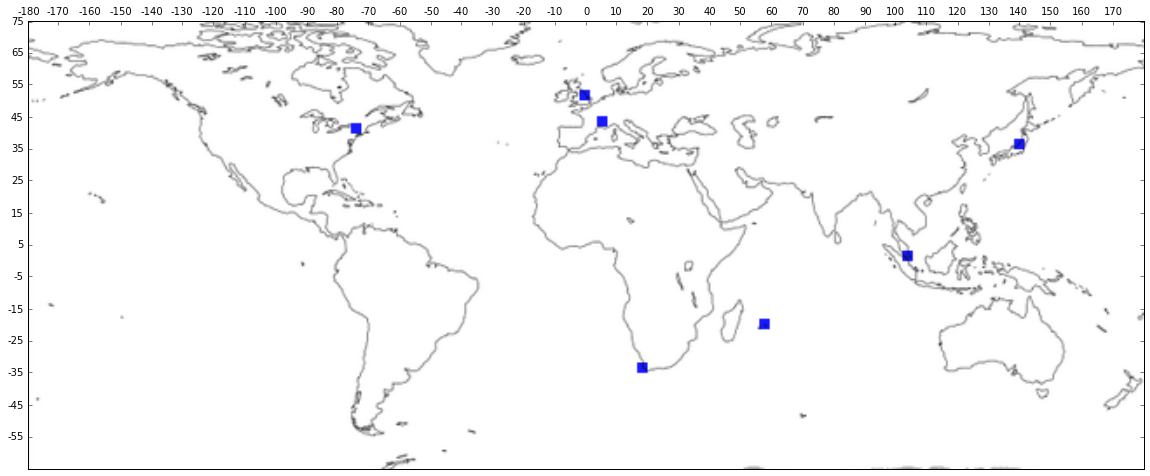

In [8]:
marseille = [5.362701, 43.286640]
london = [-0.115356, 51.486300]
newyork = [-73.994980, 40.731356]
singapore = [103.875732, 1.202228]
portlouis = [57.560120, -20.304866]
capetown = [18.459778, -33.949198]
tokyo = [139.707642, 35.788576]

siteLonLatLst = [marseille, london, newyork, singapore, portlouis, capetown, tokyo]
belmanipSiteWatcher(siteLonLatLst)